# Chicory cutting line detection using a YOLOv8 model

For the prediction of the cutting line for chicory, we use a YOLOv8 model for keypoint detection purposes. The data was created by Wout Desaever, Master student at KU leuven Bruges (2022). The data was labeled by experts from Inagro and contains the bounding box and the cutting line of the chicory. The data was converted to YOLO format and to COCO format for visualisation. 

In [1]:
# Imports
import requests
from PIL import Image
from io import BytesIO
import ultralytics
from ultralytics import YOLO
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

## Data analyis

The data folder contains a folder with images and a folder with labels in the YOLO format. This format has a .txt file for every image with one line for each annotation. Each line contains the image class, the normalized bounding box coordinates [x_center, y_center, width, height], and the normalized coordinates of the two points [x1, y1, x2, y2]. We also use a .json file with all labels in COCO format for visualization of the labels.

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


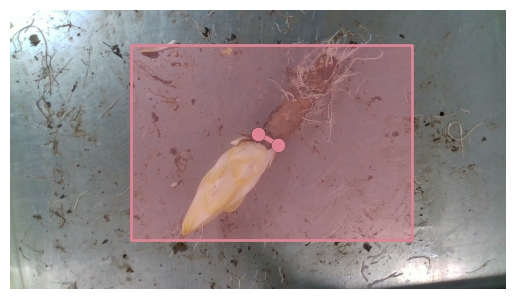

In [2]:
# Create a COCO object
coco = COCO('../../data/chicory_data_keypoints/witloof_dataset_coco.json')

# Get the annotations for this image
annotations = coco.loadAnns(coco.getAnnIds(imgIds=1))

# Get the image info
img_info = coco.loadImgs(1)[0]
height, width = img_info['height'], img_info['width']
file_name = img_info['file_name']
response = requests.get(file_name)
image = Image.open(BytesIO(response.content))

# Load and display instance annotations
plt.imshow(image); plt.axis('off')
coco.showAnns(annotations, draw_bbox=True)
plt.show()

## Data Preprocessing

For a proper pipeline, we will split our total dataset into a training, validation, and testset. De model gets trained on images from the training set. After each batch, the model is validated on the validation set. After training, we can evaluate the final model on the testset. The below command creates three autosplit .txt files that contain the paths to the images of the corresponding dataset for training, validation, and testing. 

In [3]:
# Split data in 80% training, 10% validation, and 10% test sets
ultralytics.data.utils.autosplit(path='../../data/chicory_data_keypoints/images', weights=(0.8, 0.1, 0.1), annotated_only=False)

Autosplitting images from ..\..\data\chicory_data_keypoints\images


100%|██████████| 216/216 [00:00<00:00, 5083.89it/s]


## Model training

In the next step, we will train our model. The model that we use is a pretrained YOLOv8n-pose model that was trained on the COCO dataset. We use the Ultralytics API for the training and validation phase. More info on: https://docs.ultralytics.com/tasks/pose/. All model parameters are logged during training, all parameters can be visualized using Tensorboard which will be activated below.

In [4]:
# Load a YOLOv8 model for pose estimation
model = YOLO('yolov8n-pose.yaml').load('yolov8n-pose.pt')  # build from YAML and transfer weights

# Training params
epochs = 20 # All data is sent 'epoch' times through the network
image_size = 640 # All images are resized to this size before entering the network

# Train the model
results = model.train(data='../../data/chicory_data_keypoints/witloof_dataset.yaml', epochs=epochs, imgsz=image_size)

Transferred 397/397 items from pretrained weights
Ultralytics YOLOv8.1.14 🚀 Python-3.10.11 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A500 Laptop GPU, 4096MiB)
engine\trainer: task=pose, mode=train, model=yolov8n-pose.yaml, data=../../data/chicory_data_keypoints/witloof_dataset.yaml, epochs=20, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning C:\Users\matth\OneDrive - KU Leuven\Python_Projects\machine_vision\data\chicory_data_keypoints\labels... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<00:00, 1278.27it/s]

train: New cache created: C:\Users\matth\OneDrive - KU Leuven\Python_Projects\machine_vision\data\chicory_data_keypoints\labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


KeyboardInterrupt: 

# Model validation

After training, we load the best model and perform a validation step on the test data. Afterwards, we show some predictions. 

In [ ]:
# Load a pretrained YOLOv8n model
model = YOLO('../runs/pose/train3/weights/best.pt')

In [ ]:
# Validate the model
metrics = model.val(split='test')

In [ ]:
# Predict with the model
results = model('../../data/chicory_data_keypoints/autosplit_test.txt', stream=True)  # predict on an image

# Plot results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    plt.imshow(im)
    plt.show()